<a href="https://colab.research.google.com/github/zayo1511/SimulacionProcesosFinancieros/blob/main/Valuacion_opciones_con_barrera_DiegoLozoya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

In [64]:
stock = 'COST'
endDate = dt.datetime.now()  # define hoy como fecha de fin
startDate = endDate - dt.timedelta(days=365 * 3)  # Toma datos de hace 3 años
stockData = yf.download(stock, start=startDate, end=endDate, progress=False)['Adj Close']['COST']
stockData

,COST
Date,
2021-11-01 00:00:00+00:00,472.019897
2021-11-02 00:00:00+00:00,476.933197
2021-11-03 00:00:00+00:00,482.057739
2021-11-04 00:00:00+00:00,494.811432
2021-11-05 00:00:00+00:00,492.412262
...,...
2024-10-23 00:00:00+00:00,899.169983
2024-10-24 00:00:00+00:00,893.419983
2024-10-25 00:00:00+00:00,891.219971


In [65]:
returns = stockData.pct_change().dropna()
returns

,COST
Date,
2021-11-02 00:00:00+00:00,0.010409
2021-11-03 00:00:00+00:00,0.010745
2021-11-04 00:00:00+00:00,0.026457
2021-11-05 00:00:00+00:00,-0.004849
2021-11-08 00:00:00+00:00,-0.018144
...,...
2024-10-23 00:00:00+00:00,0.006357
2024-10-24 00:00:00+00:00,-0.006395
2024-10-25 00:00:00+00:00,-0.002462


In [66]:
meanReturn = returns.mean()
# Calcula la varianza de los rendimientos
variance = returns.var()

In [67]:
S0 = stockData[-1]
K = S0*1.05
barrier = S0*1.14

<ipython-input-67-d6cad251d64d>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = stockData[-1]


In [68]:
# Estableciendo parámetros de simulación
np.random.seed(123)
T = 30 #horizonte en días
mc_sims = 4000 #N de simulaciones


# Simulando los rendimientos diarios para la acción
daily_sims = np.full(shape=(T,mc_sims), fill_value=0.0)

barrier_breached = False

for m in range(mc_sims):

    #while barrier_breached == False:
    Z = np.random.normal(size=T) # Choques aleatorios para los T días
    dailyReturns = meanReturn + np.sqrt(variance) * Z # Estimación de los rendimientos aleatorios
    daily_sims[:, m] = np.cumprod(dailyReturns + 1) * S0 # Guarda los precios simulados en este escenario

    for i in range(len(daily_sims)):
        if daily_sims[i, m] > barrier:
            daily_sims[:,m] = 0
            barrier_breached = True
            break  # Sale del bucle for si el barrier se ha superado

    barrier_breached = False  # Reinicia el indicador para el siguiente escenario

daily_sims[:, 0] # Primer escenario, día a día

array([873.08822507, 887.26297969, 891.95849118, 872.23110876,
       865.3352488 , 888.05455163, 855.89287534, 851.08874471,
       868.40807011, 857.70937967, 849.61068629, 849.19141078,
       869.40490822, 861.72829256, 856.69248617, 851.81249443,
       881.41208231, 911.78174348, 926.67839286, 933.0475695 ,
       944.47994443, 966.95210248, 954.01592757, 972.11294223,
       954.37157651, 945.96154735, 960.01176514, 939.92064358,
       938.80370144, 927.30944177])

In [69]:
daily_sims[-1, :]

array([927.30944177, 969.00766215, 876.98135914, ..., 900.07268577,
       883.91061803, 793.09294517])

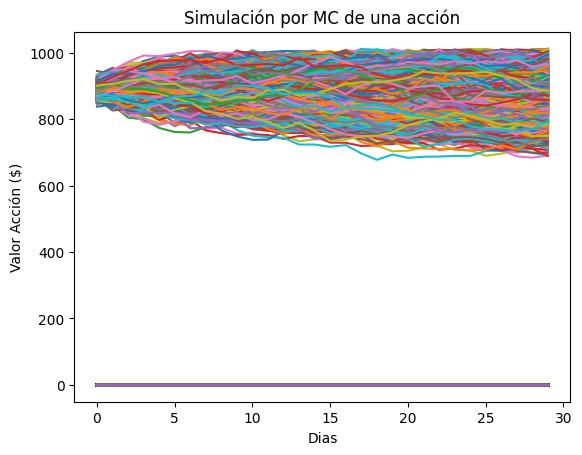

In [70]:
# Funciones de gráfica
def plotSims_single(daily_sims):
    plt.plot(daily_sims)
    plt.ylabel('Valor Acción ($)')
    plt.xlabel('Dias')
    plt.title('Simulación por MC de una acción')
    plt.show()
plotSims_single(daily_sims)

In [71]:
for i in range(30):
    if daily_sims[i, -1] == 0:
        daily_sims = np.delete(daily_sims, i, axis=1)

In [72]:
St = daily_sims[-1,:]
St

array([927.30944177, 969.00766215, 876.98135914, ..., 900.07268577,
       883.91061803, 793.09294517])

In [73]:
pt = np.maximum(K - St, 0)
pt

array([  4.03004797,   0.        ,  54.3581306 , ...,  31.26680398,
        47.42887171, 138.24654457])

In [74]:
po = (sum(pt)/mc_sims)*np.exp(-0.05*30/365)
po

180.52606376083088

In [75]:
print("El valor de la accion put es: $" + str(np.round(po, 2)))

El valor de la accion put es: $180.53
